# **Importacion de librerías y lectura del data frame**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
import io
import requests
url="https://raw.githubusercontent.com/TFM123456/Big_Data_and_Data_Science_UCM/main/datos_galicia_limpio.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode(encoding = "ISO-8859-1")))

# **DATA WRANGLING INICIAL**

In [3]:
df.groupby('causa').size()

causa
causa desconocida      830
fuego reproducido      215
intencionado         11293
negligencia            534
rayo                   104
dtype: int64

In [4]:
#Eliminamos columnas innecesarias
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [5]:
#Transformamos la columna 'fecha' a tipo numerico para luego dividir mejor las variables
df['fecha'] = pd.to_numeric(df.fecha.str.replace('-',''))
print(df['fecha'])

0        20010220
1        20010225
2        20010413
3        20010413
4        20010413
           ...   
12971    20150809
12972    20150809
12973    20150906
12974    20150908
12975    20150928
Name: fecha, Length: 12976, dtype: int64


In [6]:
#Mapeamos las variables categoricas que tienen un orden para que sean facilmente adaptable a los modelos.
df['causa'] = df.causa.map({
    'negligencia':1, 'intencionado':2, 'causa desconocida':3, 'rayo':4,
       'fuego reproducido':5
})
df['Mes'] = df.Mes.map({
    'enero':1, 'febrero':2, 'marzo':3, 'abril':4, 'mayo':5, 'junio':6, 'julio':7, 'agosto':8, 'septiembre':9, 'octubre':10,'noviembre':11, 'diciembre':12
})


df['Trimestre'] = df.Trimestre.map({
    'Q1':1, 'Q2':2, 'Q3':3, 'Q4':4
})
df['gastos'] = df.gastos.map({
    'NO INFO':-1, '< 5K ':1, '>5K':2
})
df['VELMEDIA'] = df.VELMEDIA.map({
    '2-4 m/s':2, '4-6 m/s':3, '< 2 m/s':1, '6-8 m/s':4, '> 8 m/s':5
})

df['ALTITUD'] = df.ALTITUD.map({
    'Inferior a 80':1, 'NO INFO':-1, 'Superior a 125':3, 'Entre 80-125':2
  })

In [7]:
#Notamos la gran cantidad de datos distintos en la variable municipio   
df.idmunicipio.unique()

array(['CEDEIRA', 'CARBALLO', 'LOUSAME', 'MUXÃ\x83Â\x8dA', 'OUTES',
       'MONFERO', 'SAN SADURNIÃ\x83â\x80\x98O', 'ARTEIXO', 'NOIA',
       'ARANGA', 'BRIÃ\x83â\x80\x9cN', 'SANTIAGO DE COMPOSTELA',
       'VILASANTAR', 'TEO', 'BOQUEIXÃ\x83â\x80\x9cN-CASANOVA', 'BOIRO',
       'SADA', 'NEGREIRA', 'PADRÃ\x83â\x80\x9cN', 'SANTA COMBA',
       'VIMIANZO', 'CABANA DE BERGANTIÃ\x83â\x80\x98OS', 'FISTERRA',
       'ZAS', 'PADERNE', 'NEDA', 'ORDES', 'FRADES', 'TOURO', 'RIANXO',
       'VAL DO DUBRA', 'MIÃ\x83â\x80\x98O', 'CORISTANCO', 'MAZARICOS',
       'OZA DOS RÃ\x83Â\x8dOS', 'NARÃ\x83â\x80\x9cN', 'MELIDE',
       'VALDOVIÃ\x83â\x80\x98O', 'CURTIS', 'CESURAS', 'AMES', 'RIBEIRA',
       'FERROL', 'TORDOIA', 'MESÃ\x83Â\x8dA', 'ROIS', 'TOQUES', 'MUROS',
       'CULLEREDO', 'ARES', 'PORTO DO SON', 'CARRAL', 'ABEGONDO', 'LAXE',
       'CARNOTA', 'CEE', 'MALPICA DE BERGANTIÃ\x83â\x80\x98OS',
       'DUMBRÃ\x83Â\x8dA', 'SANTISO', 'TRAZO', 'PONTECESO', 'VILARMAIOR',
       'ARZÃ\x83Å¡A', 'OLEIROS

In [8]:
#Por lo visto anteriormente, sería poco conveniente utilizar un one hot encoding para esa variable.
#Es por ello que decidimos dropear la columna para no agregar varianza a los datos. Ademas latitud y longitud brindan ya la informacion de ubicacion
df.drop(['idmunicipio'],axis=1,inplace=True)

In [9]:
df.head()

superficie     fecha        lat       lng idprovincia  causa  muertos  \
0         5.0  20010220  43.703581 -8.038777    A Coruña      1        0   
1         1.5  20010225  43.186836 -8.685470    A Coruña      2        0   
2         1.5  20010413  43.699889 -7.984566    A Coruña      1        0   
3         1.1  20010413  42.758649 -8.917814    A Coruña      3        0   
4         1.5  20010413  43.063218 -9.235604    A Coruña      2        0   

   heridos  time_ctrl  time_ext  ...  TMIN  TMAX  VELMEDIA  RACHA   SOL  \
0        0       3.55      3.55  ...   7.0  15.6         2   16.9  10.2   
1        0       2.05      2.05  ...   6.5  11.6         3   11.1  10.2   
2        0       1.50      1.50  ...  10.4  17.4         3   13.9  12.1   
3        0       3.10      3.10  ...  10.4  17.4         3   13.9  12.1   
4        0       1.35      1.35  ...  10.4  17.4         3   13.9  12.1   

   Trimestre  Mes   Año  DIR_VIENTO  PRES_RANGE  
0          1    2  2001           E         4.4  
1          1    2  2001          NE         4.7  
2          2    4  2001          NE         3.2  
3          2    4  2001          NE         3.2  
4          2    4  2001          NE         3.2  

[5 rows x 26 columns]

### Dividimos el dataset en dos (datos categoricos y numericos)

In [10]:
df_numericos = df.select_dtypes(exclude=['object','category'])
df_numericos.head(5)

superficie     fecha        lat       lng  causa  muertos  heridos  \
0         5.0  20010220  43.703581 -8.038777      1        0        0   
1         1.5  20010225  43.186836 -8.685470      2        0        0   
2         1.5  20010413  43.699889 -7.984566      1        0        0   
3         1.1  20010413  42.758649 -8.917814      3        0        0   
4         1.5  20010413  43.063218 -9.235604      2        0        0   

   time_ctrl  time_ext  personal  ...  PRECIPITACION  TMIN  TMAX  VELMEDIA  \
0       3.55      3.55        14  ...              0   7.0  15.6         2   
1       2.05      2.05         5  ...              0   6.5  11.6         3   
2       1.50      1.50         9  ...              0  10.4  17.4         3   
3       3.10      3.10        18  ...              0  10.4  17.4         3   
4       1.35      1.35        14  ...              0  10.4  17.4         3   

   RACHA   SOL  Trimestre  Mes   Año  PRES_RANGE  
0   16.9  10.2          1    2  2001         4.4  
1   11.1  10.2          1    2  2001         4.7  
2   13.9  12.1          2    4  2001         3.2  
3   13.9  12.1          2    4  2001         3.2  
4   13.9  12.1          2    4  2001         3.2  

[5 rows x 24 columns]

In [11]:
df_categorico = df.select_dtypes(exclude=['int64','float64'])
#Lo de la columna 'Mes' es un caso a considerar, ya que no es una variable categorica, pero lo transforme a 'category' para darle un orden cronologico
#La columna 'VELMEDIA' tambien es un tema a tratar, tampoco es una variable categorica
df_categorico.head(5)

idprovincia DIR_VIENTO
0    A Coruña          E
1    A Coruña         NE
2    A Coruña         NE
3    A Coruña         NE
4    A Coruña         NE

Notamos que mes y trimestre pueden aportar la misma información. Con lo cual vamos a utilizar catboost para entender la importancia de las variables a la hora de predecir la causa. Para ello nos vamos a tomar una licencia: entrenaremos el catboost con todo el dataset, ya que la idea es dropear una de las variables (mes o trimestre) segun la influencia en la predicción

In [12]:
!pip install catboost

In [13]:
from catboost import CatBoostClassifier  

In [14]:
#Instanciamos el catboost 
cs = CatBoostClassifier(random_state=42, eval_metric='MultiClass', class_weights={1:5,2:1,3:5,4:5,5:5}, iterations=200)

In [15]:
#Variables categóricas para catboost
cat_features = ['idprovincia', 'DIR_VIENTO']

In [16]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df[['causa']]

In [17]:
#Fiteamos catboost
cs.fit(X, y, cat_features=cat_features, silent=True)

Text(0.5, 1.0, 'Feature Importance')

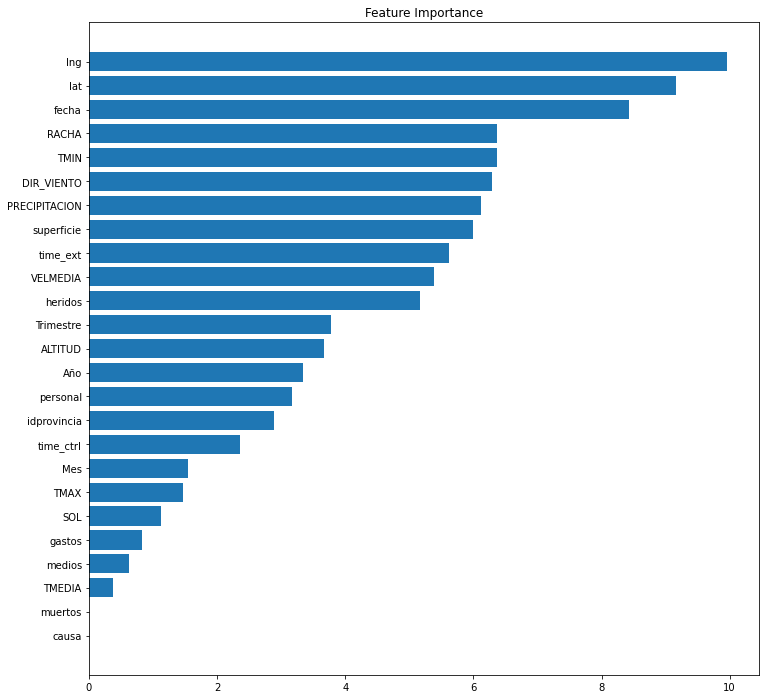

In [18]:
#Vemos la importancia de las variables. Notamos que trimestre es mejor predictor
feature_importance = cs.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df.columns)[sorted_idx])
plt.title('Feature Importance')

In [19]:
#Con lo cual procedemos a dropear la columna mes
df.drop(['Mes'],axis=1,inplace=True)

# **ANALISIS PRELIMINAR**

In [20]:
df.head()

superficie     fecha        lat       lng idprovincia  causa  muertos  \
0         5.0  20010220  43.703581 -8.038777    A Coruña      1        0   
1         1.5  20010225  43.186836 -8.685470    A Coruña      2        0   
2         1.5  20010413  43.699889 -7.984566    A Coruña      1        0   
3         1.1  20010413  42.758649 -8.917814    A Coruña      3        0   
4         1.5  20010413  43.063218 -9.235604    A Coruña      2        0   

   heridos  time_ctrl  time_ext  ...  PRECIPITACION  TMIN  TMAX  VELMEDIA  \
0        0       3.55      3.55  ...              0   7.0  15.6         2   
1        0       2.05      2.05  ...              0   6.5  11.6         3   
2        0       1.50      1.50  ...              0  10.4  17.4         3   
3        0       3.10      3.10  ...              0  10.4  17.4         3   
4        0       1.35      1.35  ...              0  10.4  17.4         3   

   RACHA   SOL  Trimestre   Año  DIR_VIENTO  PRES_RANGE  
0   16.9  10.2          1  2001           E         4.4  
1   11.1  10.2          1  2001          NE         4.7  
2   13.9  12.1          2  2001          NE         3.2  
3   13.9  12.1          2  2001          NE         3.2  
4   13.9  12.1          2  2001          NE         3.2  

[5 rows x 25 columns]

In [21]:
#Viendo dimensiones del df (29 variables o columnas y 12.976 observaciones o filas)
df.shape

(12976, 25)

In [22]:
#Tipos de datos
df.dtypes

superficie       float64
fecha              int64
lat              float64
lng              float64
idprovincia       object
causa              int64
muertos            int64
heridos            int64
time_ctrl        float64
time_ext         float64
personal           int64
medios             int64
gastos             int64
ALTITUD            int64
TMEDIA           float64
PRECIPITACION      int64
TMIN             float64
TMAX             float64
VELMEDIA           int64
RACHA            float64
SOL              float64
Trimestre          int64
Año                int64
DIR_VIENTO        object
PRES_RANGE       float64
dtype: object

In [23]:
#Totalidad de registros por columna (NO HAY DATOS FALTANTES)
df.count()

superficie       12976
fecha            12976
lat              12976
lng              12976
idprovincia      12976
causa            12976
muertos          12976
heridos          12976
time_ctrl        12976
time_ext         12976
personal         12976
medios           12976
gastos           12976
ALTITUD          12976
TMEDIA           12976
PRECIPITACION    12976
TMIN             12976
TMAX             12976
VELMEDIA         12976
RACHA            12976
SOL              12976
Trimestre        12976
Año              12976
DIR_VIENTO       12976
PRES_RANGE       12976
dtype: int64

In [24]:
#Resumen               
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   superficie     12976 non-null  float64
 1   fecha          12976 non-null  int64  
 2   lat            12976 non-null  float64
 3   lng            12976 non-null  float64
 4   idprovincia    12976 non-null  object 
 5   causa          12976 non-null  int64  
 6   muertos        12976 non-null  int64  
 7   heridos        12976 non-null  int64  
 8   time_ctrl      12976 non-null  float64
 9   time_ext       12976 non-null  float64
 10  personal       12976 non-null  int64  
 11  medios         12976 non-null  int64  
 12  gastos         12976 non-null  int64  
 13  ALTITUD        12976 non-null  int64  
 14  TMEDIA         12976 non-null  float64
 15  PRECIPITACION  12976 non-null  int64  
 16  TMIN           12976 non-null  float64
 17  TMAX           12976 non-null  float64
 18  VELMED

In [25]:
#Principales estadísticos
df.describe().T


count          mean           std           min  \
superficie     12976.0  2.586703e+00      1.863610  1.000000e+00   
fecha          12976.0  2.005656e+07  38258.294188  2.001021e+07   
lat            12976.0  4.255542e+01      0.451212  4.183382e+01   
lng            12976.0 -7.994614e+00      0.562395 -9.293500e+00   
causa          12976.0  2.088548e+00      0.527711  1.000000e+00   
muertos        12976.0  7.706535e-05      0.008779  0.000000e+00   
heridos        12976.0  4.623921e-04      0.021499  0.000000e+00   
time_ctrl      12976.0  1.781149e+00      0.894420  4.000000e-02   
time_ext       12976.0  1.781149e+00      0.894420  4.000000e-02   
personal       12976.0  1.228152e+01      7.252796  0.000000e+00   
medios         12976.0  1.964396e+00      1.674277  0.000000e+00   
gastos         12976.0 -6.283909e-01      0.839125 -1.000000e+00   
ALTITUD        12976.0  1.799938e+00      1.337718 -1.000000e+00   
TMEDIA         12976.0  1.658466e+01      5.954963 -1.300000e+00   
PRECIPITACION  12976.0  1.321671e-01      0.338685  0.000000e+00   
TMIN           12976.0  9.717810e+00      6.252533 -8.600000e+00   
TMAX           12976.0  2.345237e+01      7.001220  5.600000e+00   
VELMEDIA       12976.0  1.618604e+00      0.865056  1.000000e+00   
RACHA          12976.0  8.537230e+00      3.298872  1.700000e+00   
SOL            12976.0  8.547102e+00      3.549735  0.000000e+00   
Trimestre      12976.0  2.337855e+00      0.989067  1.000000e+00   
Año            12976.0  2.005593e+03      3.828872  2.001000e+03   
PRES_RANGE     12976.0  3.836675e+00      1.639618  0.000000e+00   

                        25%           50%           75%           max  
superficie     1.250000e+00  2.000000e+00  3.000000e+00  1.020000e+01  
fecha          2.003019e+07  2.005020e+07  2.009023e+07  2.015122e+07  
lat            4.218937e+01  4.247016e+01  4.293220e+01  4.373071e+01  
lng           -8.422458e+00 -7.987553e+00 -7.556844e+00 -6.771548e+00  
causa          2.000000e+00  2.000000e+00  2.000000e+00  5.000000e+00  
muertos        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
heridos        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
time_ctrl      1.170000e+00  1.500000e+00  2.310000e+00  4.190000e+00  
time_ext       1.170000e+00  1.500000e+00  2.310000e+00  4.190000e+00  
personal       6.000000e+00  1.100000e+01  1.600000e+01  3.300000e+01  
medios         1.000000e+00  2.000000e+00  3.000000e+00  8.000000e+00  
gastos        -1.000000e+00 -1.000000e+00 -1.000000e+00  2.000000e+00  
ALTITUD        1.000000e+00  2.000000e+00  3.000000e+00  3.000000e+00  
TMEDIA         1.240000e+01  1.740000e+01  2.110000e+01  3.120000e+01  
PRECIPITACION  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
TMIN           5.200000e+00  1.060000e+01  1.490000e+01  2.340000e+01  
TMAX           1.860000e+01  2.340000e+01  2.840000e+01  4.200000e+01  
VELMEDIA       1.000000e+00  1.000000e+00  2.000000e+00  5.000000e+00  
RACHA          6.100000e+00  8.100000e+00  1.060000e+01  2.830000e+01  
SOL            6.500000e+00  9.400000e+00  1.120000e+01  1.480000e+01  
Trimestre      1.000000e+00  3.000000e+00  3.000000e+00  4.000000e+00  
Año            2.003000e+03  2.005000e+03  2.009000e+03  2.015000e+03  
PRES_RANGE     2.600000e+00  3.600000e+00  4.900000e+00  8.600000e+00

In [26]:
#Resumen: los datos están relacionados a incendios forestales. Presenta 29 variables y no cuenta con datos faltantes

# **ANALISIS UNIVARIADO**

In [27]:
#Variable tiempo de extincion del incendio medida en minutos  
df.time_ext.describe()

count    12976.000000
mean         1.781149
std          0.894420
min          0.040000
25%          1.170000
50%          1.500000
75%          2.310000
max          4.190000
Name: time_ext, dtype: float64

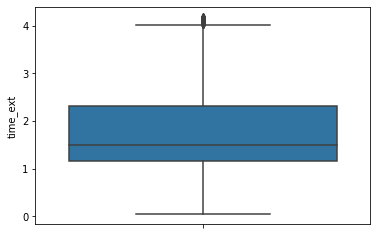

In [28]:
#La mediana ronda los 1 hora y 5 minutos aprox (menor a la media de 1 hora y 78 minutos). Notamos ciertos outliers por encima de 4 minutos, pero desde el punto de vista práctico..
#..ese tiempo superior en extincion es una posibilidad concreta
from seaborn import boxplot
boxplot(y=df.time_ext, orient='v')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


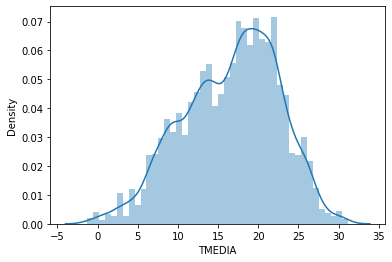

In [29]:
#Histograma de la temperatura media en incendios
from seaborn import distplot
distplot(df.TMEDIA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


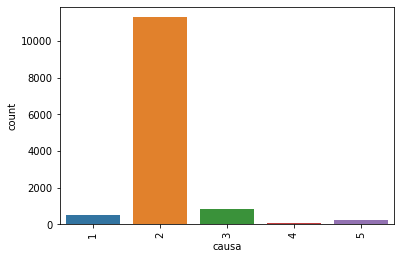

In [30]:
#Cantidad de incendios por causa. Observamos que prevalece la causa "intencionada".
sns.countplot(df['causa'])
plt.xticks(rotation=90);

In [31]:
#Frecuencia de las causas (misma info que el grafico anterior). Vemos que tal vez esté un poco desbalanceado el dataset (tema a analizar cuando avancemos en el proyecto)
df.causa.value_counts()

2    11293
3      830
1      534
5      215
4      104
Name: causa, dtype: int64

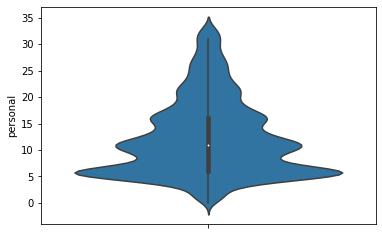

In [32]:
#Cantidad de personal que intervino. La mediana se observa alrededor de las 10 personas, aunque la mayor cantidad de veces (frecuencia absoluta) intervinieron alrededor de 5 personas
from seaborn import violinplot
violinplot(y=df.personal,data=df, orient="vertical")


In [33]:
df.personal.describe()

count    12976.000000
mean        12.281520
std          7.252796
min          0.000000
25%          6.000000
50%         11.000000
75%         16.000000
max         33.000000
Name: personal, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


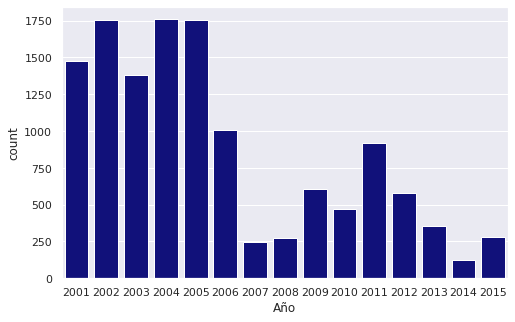

In [34]:
#Cantidad de incendios por año. Observamos que la cantidad de incendio fue mayor en los primeros años observados (2001 a 2005)
sns.set(rc = {'figure.figsize':(8,5)})
sns.countplot(df['Año'],color='darkblue')

# **ANALISIS BIVARIADO**

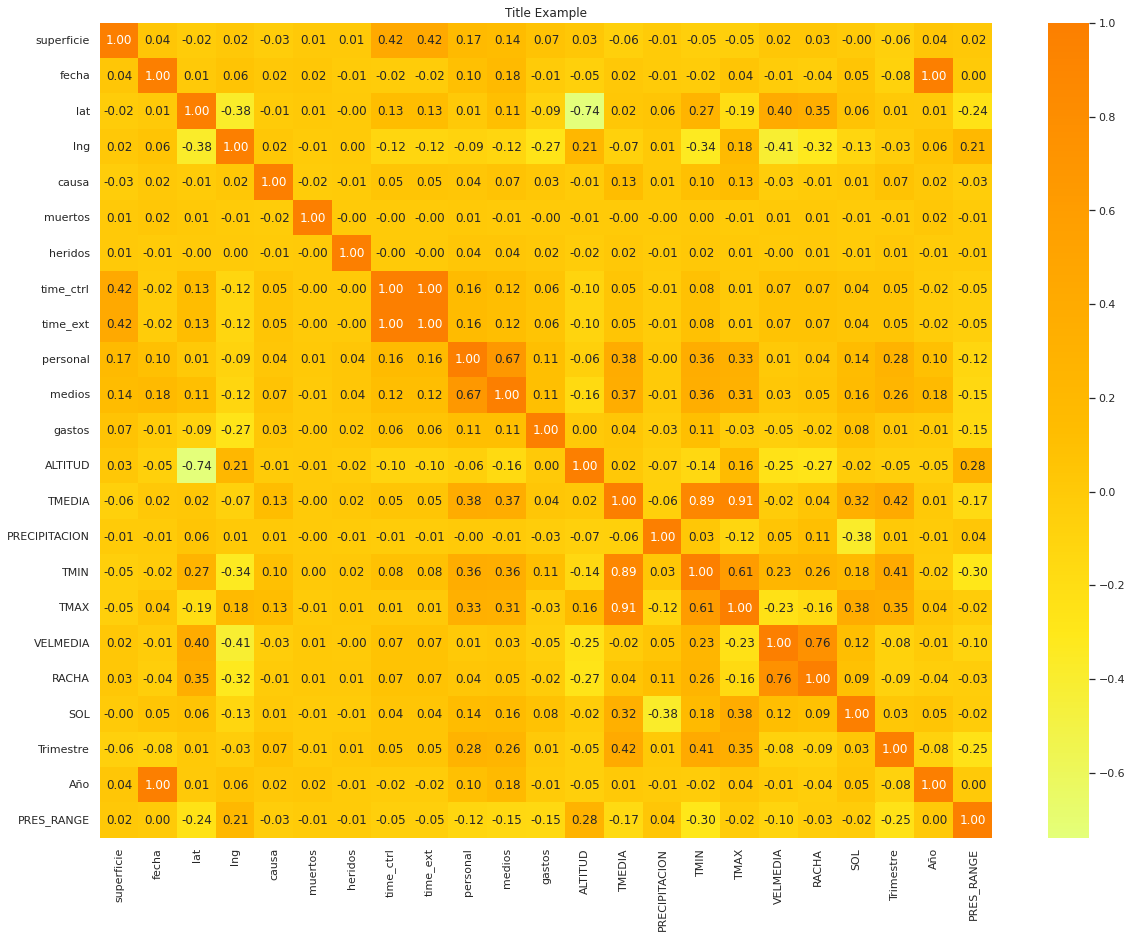

In [35]:
#Hagamos un HeatMap del df
plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(df.corr(), annot = True, cmap = 'Wistia',fmt=".2f")
plt.title("Title Example")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


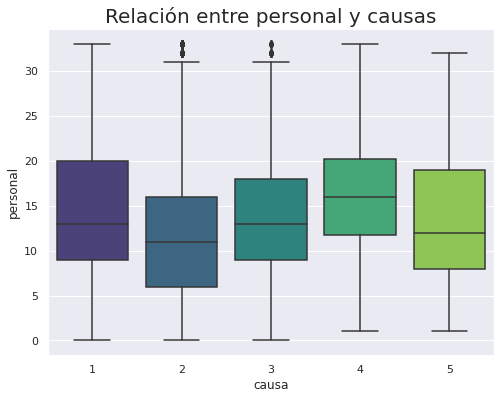

In [36]:
# Causa vs Personal: notamos que los incendios por causas de negligencia o rayo requirieron mayor cantidad de personal para controlar el incendio
plt.rcParams['figure.figsize'] = (8, 6)
sns.boxplot(df['causa'], df['personal'], palette = 'viridis')
plt.title('Relación entre personal y causas', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


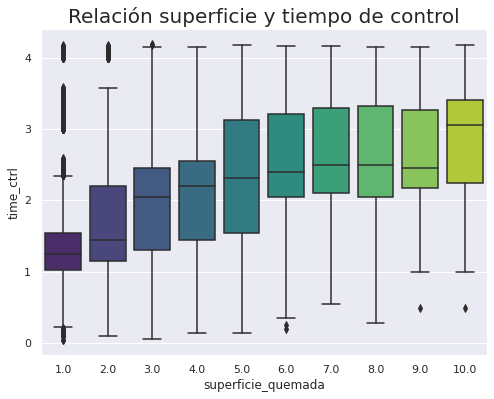

In [37]:
# En este grafico veremos que a mayor superficie mayor es la cantidad de tiempo para controlarlo.
df['superficie_quemada']= round(df['superficie'],0)      # se redondeo la superficie para tener un grafico acorde
plt.rcParams['figure.figsize'] = (8, 6)
sns.boxplot(df['superficie_quemada'], df['time_ctrl'], palette = 'viridis')
plt.title('Relación superficie y tiempo de control', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


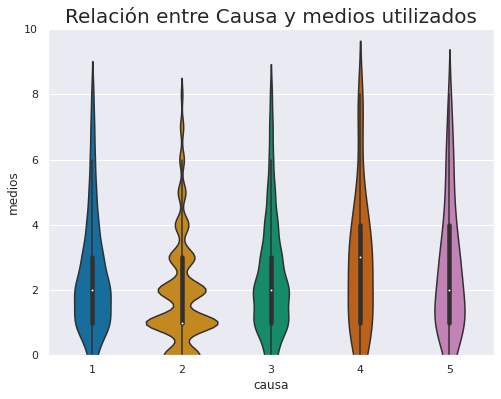

In [38]:
# Se utilizó mayor cantidad de medios cuando la causa de incendio fue un rayo. De manera inversa, en un incendio intencionado utilizó menor cantidad de medios.
plt.rcParams['figure.figsize'] = (8, 6)
sns.violinplot(df['causa'], df['medios'], palette = 'colorblind')
plt.ylim(0, 10)
plt.title('Relación entre Causa y medios utilizados', fontsize = 20, fontweight = 30)
plt.show()        

Text(0, 0.5, 'Superficie')

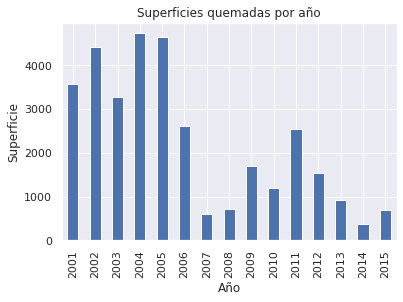

In [39]:
# Confirmamos que no solo la cantidad de incendios fue mayor desde 2001 a 2005 (visto en analisis univariado) 
# sino que tambien las superficies quemadas fueron mayores en esos años
plt.figure(figsize=(6 ,4))
año=df.groupby('Año')['superficie'].sum().plot(kind='bar')
plt.title("Superficies quemadas por año")
plt.xlabel("Año")
plt.ylabel("Superficie")


Text(0, 0.5, 'Superficie')

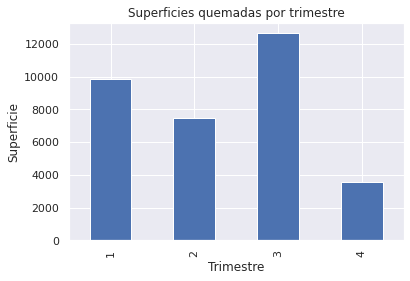

In [40]:
#Notamos cierta estacionalidad en las superficies quemadas: las mayores se dan en el 3er trimestre y (en segundo lugar) en el 1er trimestre. 
#Mientras que las menores se dan en el cuarto trimestre 
plt.figure(figsize=(6 ,4))
año=df.groupby('Trimestre')['superficie'].sum().plot(kind='bar')
plt.title("Superficies quemadas por trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Superficie")

# **ANALISIS MULTIVARIADO**

In [41]:
df

superficie     fecha        lat       lng idprovincia  causa  muertos  \
0            5.00  20010220  43.703581 -8.038777    A Coruña      1        0   
1            1.50  20010225  43.186836 -8.685470    A Coruña      2        0   
2            1.50  20010413  43.699889 -7.984566    A Coruña      1        0   
3            1.10  20010413  42.758649 -8.917814    A Coruña      3        0   
4            1.50  20010413  43.063218 -9.235604    A Coruña      2        0   
...           ...       ...        ...       ...         ...    ...      ...   
12971        2.20  20150809  42.104697 -8.312897  Pontevedra      2        0   
12972        1.07  20150809  42.090426 -8.782721  Pontevedra      2        0   
12973        1.45  20150906  42.103959 -8.522512  Pontevedra      2        0   
12974        5.94  20150908  42.554722 -8.018586  Pontevedra      2        0   
12975        3.20  20150928  42.243441 -8.322375  Pontevedra      2        0   

       heridos  time_ctrl  time_ext  ...  TMIN  TMAX  VELMEDIA  RACHA   SOL  \
0            0       3.55      3.55  ...   7.0  15.6         2   16.9  10.2   
1            0       2.05      2.05  ...   6.5  11.6         3   11.1  10.2   
2            0       1.50      1.50  ...  10.4  17.4         3   13.9  12.1   
3            0       3.10      3.10  ...  10.4  17.4         3   13.9  12.1   
4            0       1.35      1.35  ...  10.4  17.4         3   13.9  12.1   
...        ...        ...       ...  ...   ...   ...       ...    ...   ...   
12971        0       2.25      2.25  ...  14.6  32.2         1    8.9  12.7   
12972        0       1.47      1.47  ...  14.6  32.2         1    8.9  12.7   
12973        0       1.32      1.32  ...  12.1  26.6         1    4.2  11.7   
12974        0       1.27      1.27  ...  14.8  24.5         1    5.3   9.2   
12975        0       1.29      1.29  ...  13.3  26.3         1    6.1   9.3   

       Trimestre   Año  DIR_VIENTO  PRES_RANGE  superficie_quemada  
0              1  2001           E         4.4                 5.0  
1              1  2001          NE         4.7                 2.0  
2              2  2001          NE         3.2                 2.0  
3              2  2001          NE         3.2                 1.0  
4              2  2001          NE         3.2                 2.0  
...          ...   ...         ...         ...                 ...  
12971          3  2015           W         5.6                 2.0  
12972          3  2015           W         5.6                 1.0  
12973          3  2015           W         1.7                 1.0  
12974          3  2015          NE         2.0                 6.0  
12975          3  2015          NE         2.2                 3.0  

[12976 rows x 26 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


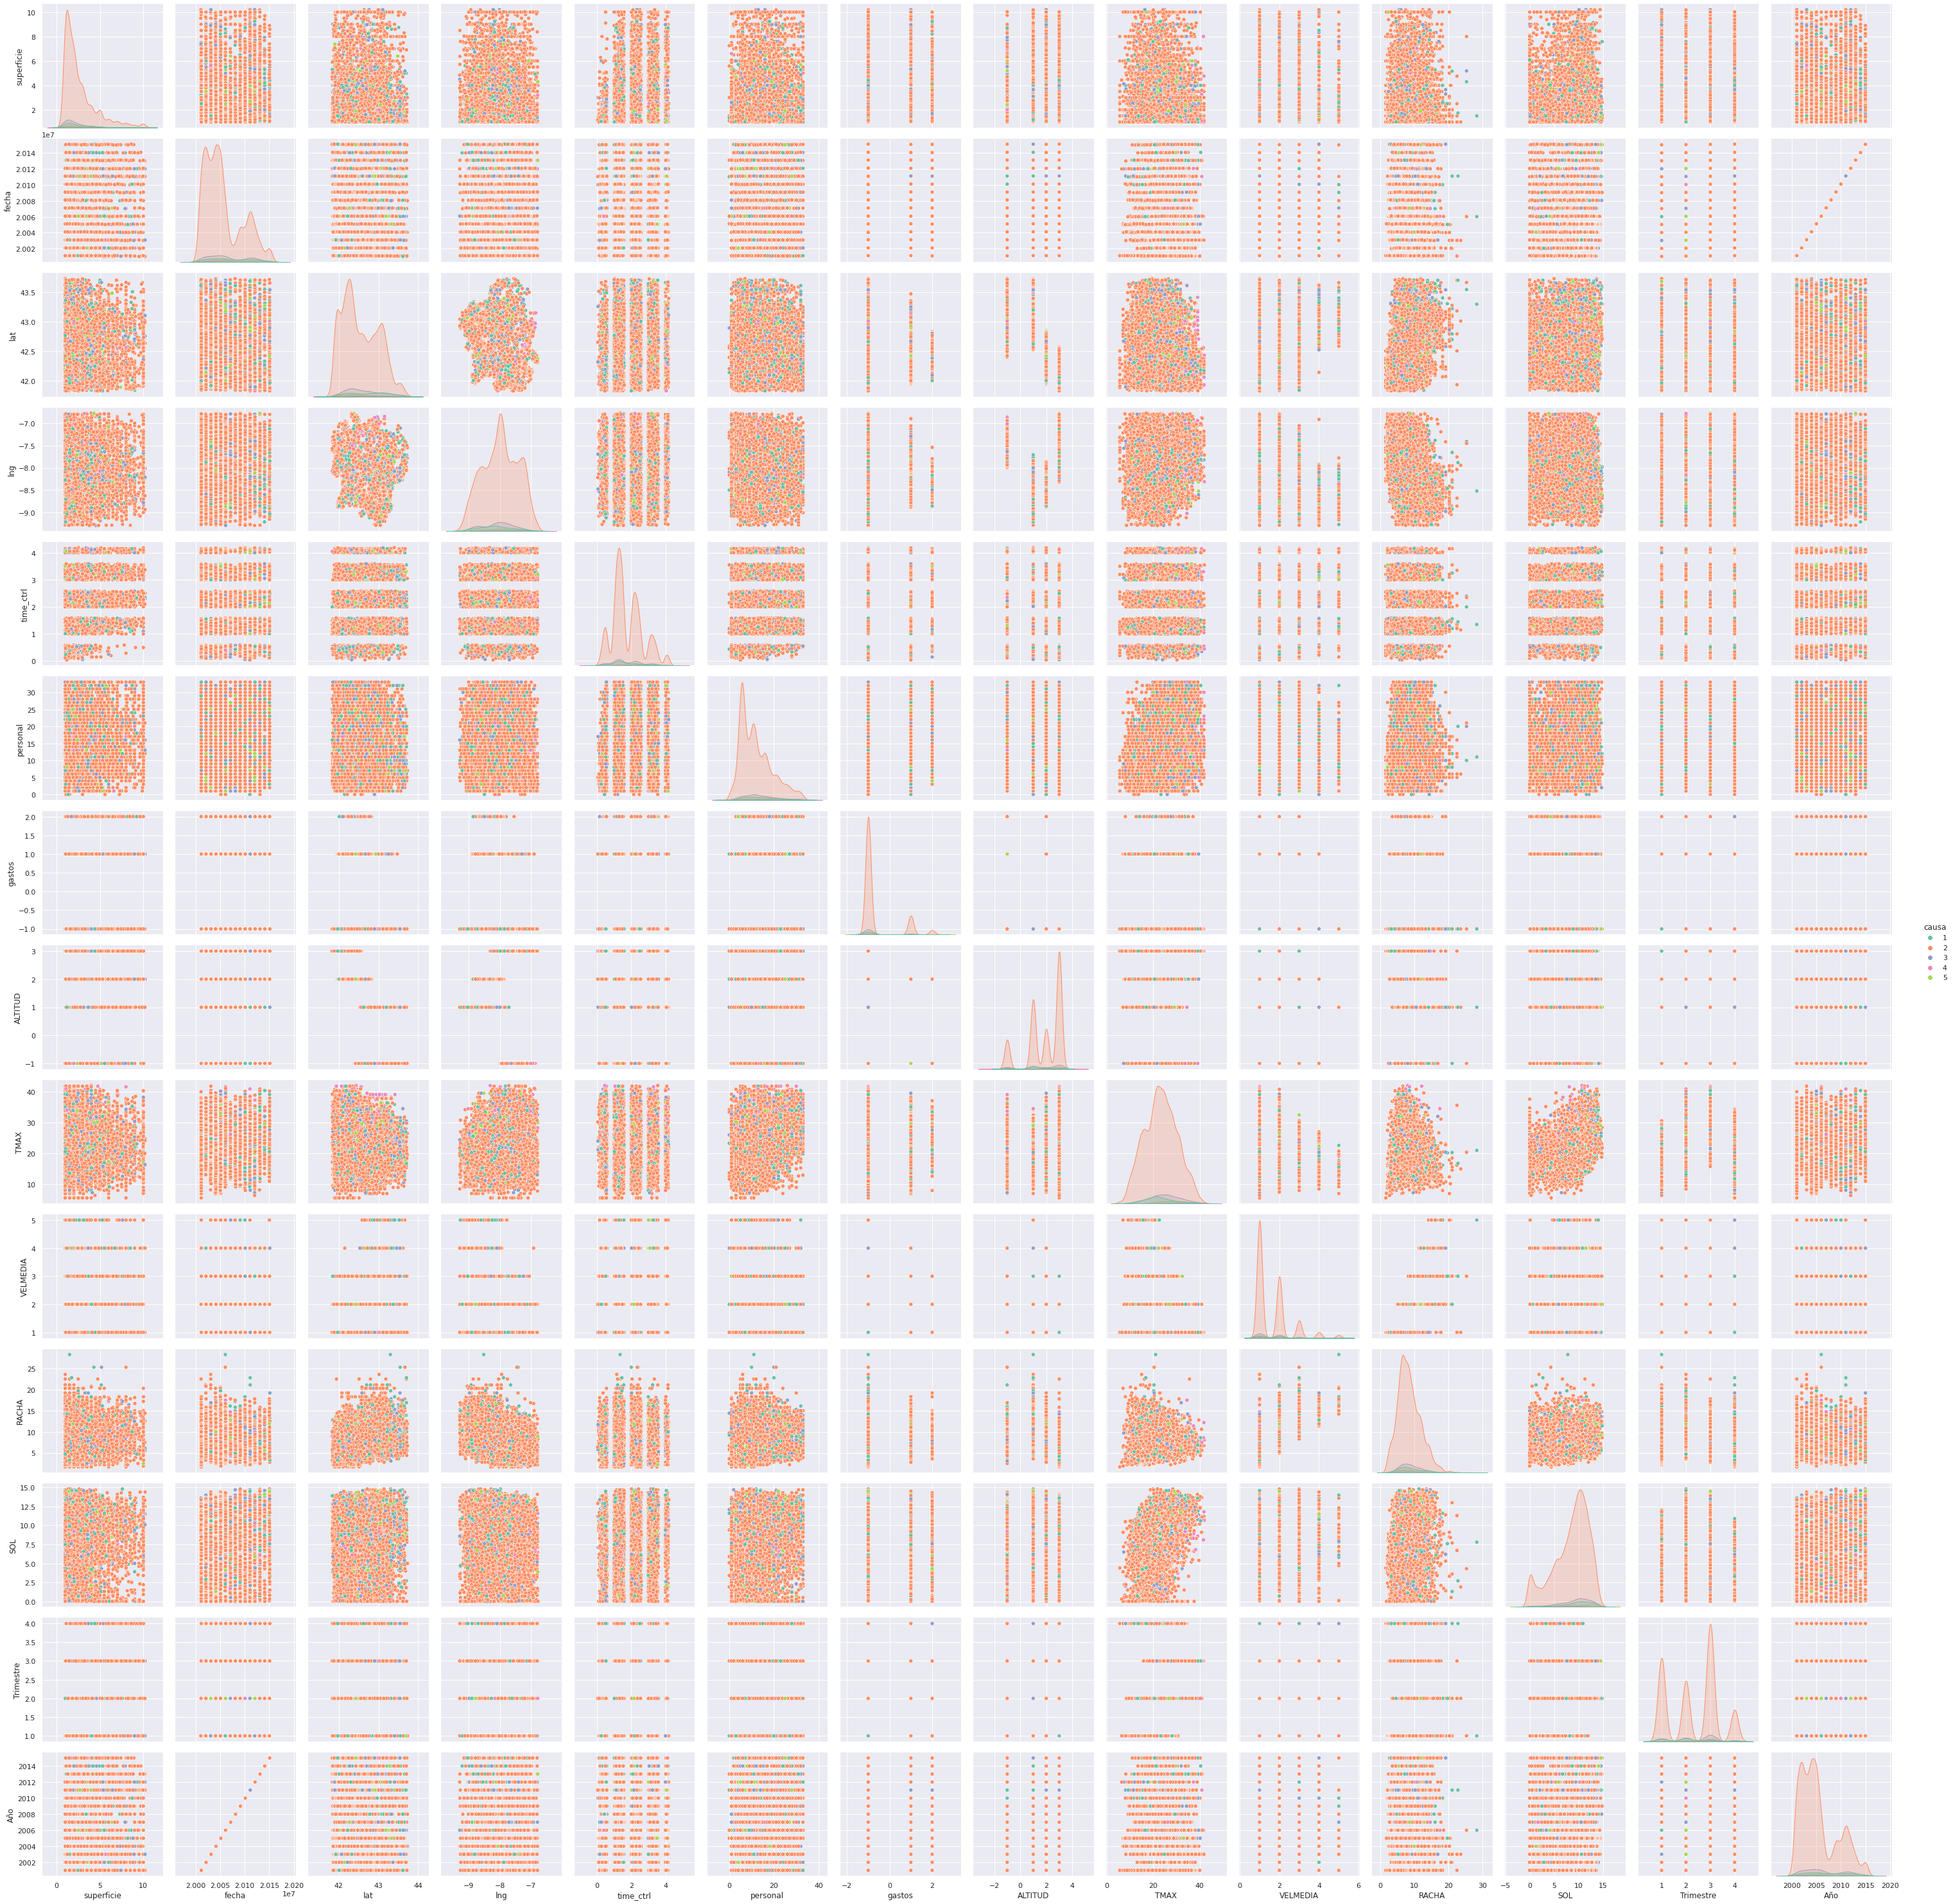

In [42]:
#Pairplot: cruzamos las variables distinguiendo por causa. No se puede observar patrones claros.
df_=df.drop(columns=['TMIN','TMEDIA','heridos','muertos','time_ext','medios','PRECIPITACION','PRES_RANGE','superficie_quemada'],inplace=False) #Dropeamos algunas columnas para que tener una mejor vista
sns.pairplot(df_,hue = 'causa' , size = 3 , palette = 'Set2')

In [43]:
# Podemos observar algunas situaciones: hay mayor% de falta de información de gastos que de información.
# En el caso de incendios provocados por rayos, no existen registros que expongan mayores gastos a 5k
# Independientemente las causas, prevalecen los registros que exponen gastos menores a 5k respecto a los que superan los 5k
df.groupby(['causa','gastos']).size()/df.groupby(['causa']).size()

causa  gastos
1      -1        0.799625
        1        0.151685
        2        0.048689
2      -1        0.834234
        1        0.133800
        2        0.031967
3      -1        0.840964
        1        0.126506
        2        0.032530
4      -1        0.846154
        1        0.153846
5      -1        0.674419
        1        0.260465
        2        0.065116
dtype: float64

In [44]:
#Observamos que en general habría pocos incendios sin info respecto a la altitud, salvo en caso de que la causa sea un rayo (44% sin info)
df.groupby(['causa','ALTITUD']).size()/df.groupby(['causa']).size()

causa  ALTITUD
1      -1         0.164794
        1         0.408240
        2         0.181648
        3         0.245318
2      -1         0.114319
        1         0.271407
        2         0.156203
        3         0.458071
3      -1         0.180723
        1         0.275904
        2         0.145783
        3         0.397590
4      -1         0.442308
        1         0.038462
        2         0.105769
        3         0.413462
5      -1         0.130233
        1         0.153488
        2         0.320930
        3         0.395349
dtype: float64

## Así quedaría el dataset final que nos servirá como base a los modelos que se construirán

In [45]:
dataset = df

In [46]:
dataset

superficie     fecha        lat       lng idprovincia  causa  muertos  \
0            5.00  20010220  43.703581 -8.038777    A Coruña      1        0   
1            1.50  20010225  43.186836 -8.685470    A Coruña      2        0   
2            1.50  20010413  43.699889 -7.984566    A Coruña      1        0   
3            1.10  20010413  42.758649 -8.917814    A Coruña      3        0   
4            1.50  20010413  43.063218 -9.235604    A Coruña      2        0   
...           ...       ...        ...       ...         ...    ...      ...   
12971        2.20  20150809  42.104697 -8.312897  Pontevedra      2        0   
12972        1.07  20150809  42.090426 -8.782721  Pontevedra      2        0   
12973        1.45  20150906  42.103959 -8.522512  Pontevedra      2        0   
12974        5.94  20150908  42.554722 -8.018586  Pontevedra      2        0   
12975        3.20  20150928  42.243441 -8.322375  Pontevedra      2        0   

       heridos  time_ctrl  time_ext  ...  TMIN  TMAX  VELMEDIA  RACHA   SOL  \
0            0       3.55      3.55  ...   7.0  15.6         2   16.9  10.2   
1            0       2.05      2.05  ...   6.5  11.6         3   11.1  10.2   
2            0       1.50      1.50  ...  10.4  17.4         3   13.9  12.1   
3            0       3.10      3.10  ...  10.4  17.4         3   13.9  12.1   
4            0       1.35      1.35  ...  10.4  17.4         3   13.9  12.1   
...        ...        ...       ...  ...   ...   ...       ...    ...   ...   
12971        0       2.25      2.25  ...  14.6  32.2         1    8.9  12.7   
12972        0       1.47      1.47  ...  14.6  32.2         1    8.9  12.7   
12973        0       1.32      1.32  ...  12.1  26.6         1    4.2  11.7   
12974        0       1.27      1.27  ...  14.8  24.5         1    5.3   9.2   
12975        0       1.29      1.29  ...  13.3  26.3         1    6.1   9.3   

       Trimestre   Año  DIR_VIENTO  PRES_RANGE  superficie_quemada  
0              1  2001           E         4.4                 5.0  
1              1  2001          NE         4.7                 2.0  
2              2  2001          NE         3.2                 2.0  
3              2  2001          NE         3.2                 1.0  
4              2  2001          NE         3.2                 2.0  
...          ...   ...         ...         ...                 ...  
12971          3  2015           W         5.6                 2.0  
12972          3  2015           W         5.6                 1.0  
12973          3  2015           W         1.7                 1.0  
12974          3  2015          NE         2.0                 6.0  
12975          3  2015          NE         2.2                 3.0  

[12976 rows x 26 columns]

## Iniciamos con la puesta en marcha de los modelos de clasificación

In [47]:
dataset.groupby('causa').size()

causa
1      534
2    11293
3      830
4      104
5      215
dtype: int64

Creamos el dataframe que almacenara los resultados de las metricas obtenidas en los modelos

In [48]:
resultados_df = pd.DataFrame(columns=['Método','Accuracy','Recall','Precision','ROCAUC','F1-Score','Tiempo'])

def guardo_resultados(metodo, y_test, y_pred, y_test_proba, tiempo_ejecucion):
    from sklearn import metrics
    
    resultados = {}
    
    resultados['Método'] = metodo
    resultados['Accuracy'] = metrics.accuracy_score(y_test, y_pred)
    resultados['Recall'] = metrics.recall_score(y_test, y_pred, average='weighted')
    resultados['Precision'] = metrics.precision_score(y_test, y_pred, zero_division = 1, average='weighted')
    resultados['ROCAUC'] = metrics.roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    resultados['F1-Score'] = metrics.f1_score(y_test, y_pred, average='weighted')
    resultados['Tiempo'] = tiempo_ejecucion

    return resultados

## MODELOS

### A continuación probaremos diferentes modelos de Machine Learning, testeando su precisión y ajuste sobre el dataset propuesto.

### KNN 

In [49]:
df = dataset.copy()

In [50]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [51]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

Fit y transformacion del X_train

In [52]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden (como si lo tiene por ejemplo, los meses del año)
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(X_train[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
X_train.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
X_train= pd.concat([X_train, _ohe],axis=1)
X_train.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [53]:
#Instanciamos standar scaler
se=StandardScaler()

# Escalamos los datos
X_train=pd.DataFrame(se.fit_transform(X_train),columns=X_train.columns)

In [54]:
#Instanciar PCA 
pca=PCA(random_state=42,n_components=0.90)

#Transformamos el data frame
X_train_decomp=pca.fit_transform(X_train)

In [55]:
#Mostramos cantidad de columnas (19, que son las componentes que explican el 90% de variabilidad)
X_train_decomp.shape

(9083, 19)

Transformacion de los datos del X_test

In [56]:
#Se realiza One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(X_test[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
X_test.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
X_test= pd.concat([X_test, _ohe],axis=1)
X_test.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [57]:
# Escalamos los datos
X_test=pd.DataFrame(se.transform(X_test),columns=X_test.columns)

#Transformamos el data frame
X_test_decomp=pca.transform(X_test)

#Mostramos cantidad de columnas (19, que son las componentes que explican el 90% de variabilidad)
X_test_decomp.shape

(3893, 19)

Predict y evaluacion

In [58]:
#Importamos el modelo
from sklearn.neighbors import KNeighborsClassifier

In [59]:
#Fiteamos
knn = KNeighborsClassifier()

start= time.time()
knn.fit(X_train_decomp,y_train)
end= time.time()
tiempo_ejecucion= (end-start)

In [60]:
y_train_pred = knn.predict(X_train_decomp) #Prediccion en Train
y_test_pred = knn.predict(X_test_decomp) #Prediccion en Test

y_test_proba = knn.predict_proba(X_test_decomp) #Prediccion en test para ROCAUC

In [61]:
resultados = guardo_resultados('k-Nearest-Neighbor', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [62]:
#Creamos la matriz de confusión
matriz_knn = confusion_matrix(y_test, y_test_pred)

### RANDOM FOREST

In [63]:
#Importamos los modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Creacion del arbol de decision y Random Forest

In [64]:
df = dataset.copy()

In [65]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [66]:
#Separamos en X e y
X = df.drop(["causa"], axis=1)
y = df["causa"]
#Separamos en train y test!
(X_train, X_test,
y_train, y_test) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [67]:
#Creamos un arbol de decisión sencillo y lo fiteamos
tree = DecisionTreeClassifier(random_state=11)
start= time.time()
tree.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [68]:
y_train_pred = tree.predict(X_train) #Prediccion en train
y_test_pred = tree.predict(X_test) #Prediccion en Test

y_test_proba = tree.predict_proba(X_test) #Prediccion en test probability

In [69]:
resultados = guardo_resultados('Arbol de Decision', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [70]:
#Creamos la matriz de confusión
matriz_decisionTree = confusion_matrix(y_test, y_test_pred)

In [71]:
#Creamos un random forest!
Random_Forest = RandomForestClassifier(random_state=11, n_estimators=200,
                               class_weight="balanced", max_features="log2")
start= time.time()
Random_Forest.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [72]:
y_train_pred = Random_Forest.predict(X_train) #Prediccion en train
y_test_pred = Random_Forest.predict(X_test) #Prediccion en Test

y_test_proba = Random_Forest.predict_proba(X_test) #Prediccion en test probability

In [73]:
resultados = guardo_resultados('Random Forest', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [74]:
#Creamos la matriz de confusión
matriz_randomForest = confusion_matrix(y_test, y_test_pred)

### CATBOOST

In [75]:
!pip install catboost

In [76]:
from catboost import CatBoostClassifier     

In [77]:
df = dataset.copy()

In [78]:
#Variables categóricas para catboost
cat_features = ['idprovincia', 'DIR_VIENTO']

In [79]:
#Instanciamos el catboost con class weights para intentar balancear el dataset
cs = CatBoostClassifier(random_state=42, eval_metric='MultiClass', class_weights={1:5,2:1,3:5,4:5,5:5}, iterations=200)

In [80]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [81]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

In [82]:
#Entrenamos el modelo
start= time.time()
cs.fit(X_train,y_train, cat_features = ['idprovincia', 'DIR_VIENTO'], silent=True)
end= time.time()
tiempo_ejecucion = (end-start)

In [83]:
y_train_pred = cs.predict(X_train) #Prediccion en Train
y_test_pred = cs.predict(X_test) #Prediccion en Test

t_test_proba = cs.predict_proba(X_test) #Prediccion en Test probability

In [84]:
resultados = guardo_resultados('Catboost', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [85]:
#Creamos la matriz de confusión
matriz_catboost = confusion_matrix(y_test, y_test_pred)

### Support Vector Machine (Polinomial)

In [86]:
df = dataset.copy()

In [87]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [88]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [89]:
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (9083, 35), (9083,)
Test Data: (3893, 35), (3893,)


In [90]:
from sklearn import svm

#Entrenamos el SVM en un Kernel Polinomial debido a sus multiples clases en el target
svm = svm.SVC(kernel='poly', degree=3, C=1, probability=True)
start= time.time()
svm.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [91]:
y_train_pred = svm.predict(X_train) #Prediccion en Train
y_test_pred = svm.predict(X_test) #Prediccion en Test

y_test_proba = svm.predict_proba(X_test) #Prediccion en Test probability

In [92]:
resultados = guardo_resultados('Support Vector Machine', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [93]:
#Creamos la matriz de confusión
matriz_svm = confusion_matrix(y_test, y_test_pred)

## Primera técnica de balanceo: Random Over Sampling (ROS)
Vemos un pronunciado desbalanceo de clases. Por lo tanto a partir de ésta seccion vamos a aplicar distintas tecnicas para intentar mejorar los resultados obtenidos por los distintos algoritmos.

### Random Forest Ros

In [94]:
#Mostramos el desbalanceo
dataset.groupby('causa').size()

causa
1      534
2    11293
3      830
4      104
5      215
dtype: int64

In [95]:
#Instalamos librería para aprendizaje desbalanceado
#pip install imbalanced-learn

In [96]:
df = dataset.copy()

In [97]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [98]:
from sklearn.ensemble import RandomForestClassifier
#Creamos un random forest!
Random_Forest_Ros= RandomForestClassifier(random_state=11, n_estimators=500,
                               class_weight="balanced_subsample")


In [99]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [100]:
#Separamos en train y test
(X_train, X_test,
y_train, y_test) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [101]:
#Importamos Smote y lo aplicamos sobre train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X_train, y_train)

In [102]:
start= time.time()
Random_Forest_Ros.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


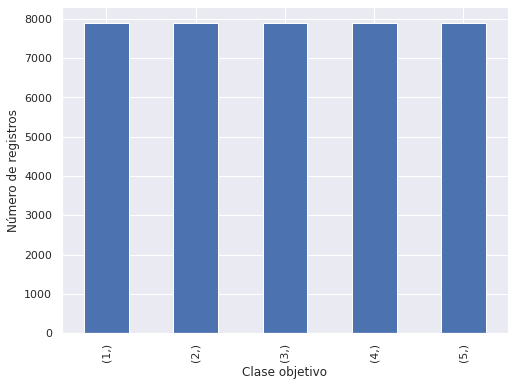

In [103]:
#Vemos el balanceo que produce el ROS
count = y_train.value_counts() 
count.plot.bar() 
plt.ylabel('Número de registros') 
plt.xlabel('Clase objetivo') 
plt.show()

In [104]:
y_train_pred = Random_Forest_Ros.predict(X_train) #Prediccion en train
y_test_pred = Random_Forest_Ros.predict(X_test) #Prediccion en Test

y_test_proba = Random_Forest_Ros.predict_proba(X_test) #Prediccion en Test probability

In [105]:
resultados = guardo_resultados('Random Forest - Random-Over-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [106]:
#Creamos la matriz de confusión
matriz_randomForest_ros = confusion_matrix(y_test, y_test_pred)

### Catboost-Ros

In [107]:
from catboost import CatBoostClassifier

In [108]:
df = dataset.copy()

In [109]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [110]:
#Instanciamos el catboost para intentar balancear el dataset
cs_Ros = CatBoostClassifier(random_state=42, eval_metric='MultiClass', class_weights={1:5,2:1,3:5,4:5,5:5}, iterations=200)

In [111]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [112]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

In [113]:
#Importamos Random Over Sampling y lo aplicamos sobre train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X_train, y_train)

In [114]:
#Entrenamos el modelo
start= time.time()
cs_Ros.fit(X_train,y_train, silent=True)
end= time.time()
tiempo_ejecucion = (end-start)

In [115]:
y_train_pred = cs_Ros.predict(X_train) #Prediccion en Train
y_test_pred = cs_Ros.predict(X_test) #Prediccion en Test

y_test_proba = cs_Ros.predict_proba(X_test) #Prediccion en Test proability

In [116]:
resultados = guardo_resultados('Catboost - Random-Over-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [117]:
#Creamos la matriz de confusión
matriz_catboost_ros = confusion_matrix(y_test, y_test_pred)

### Máquina de soporte vectorial- Ros

In [118]:
df = dataset.copy()

In [119]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [120]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [121]:
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (9083, 35), (9083,)
Test Data: (3893, 35), (3893,)


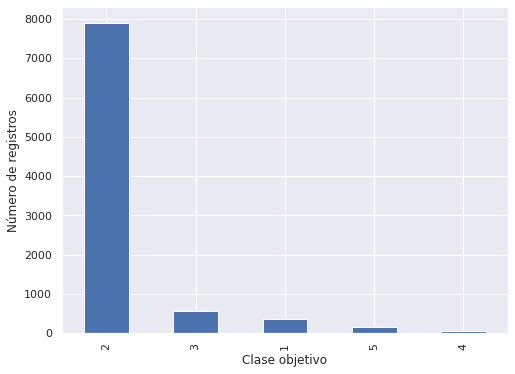

In [122]:
#Vemos el balanceo que produce el ROS
count = y_train.value_counts() 
count.plot.bar() 
plt.ylabel('Número de registros') 
plt.xlabel('Clase objetivo') 
plt.show()

In [123]:
#Importamos Random Over Sampling y lo aplicamos sobre train
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train, y_train= ros.fit_resample(X_train, y_train)

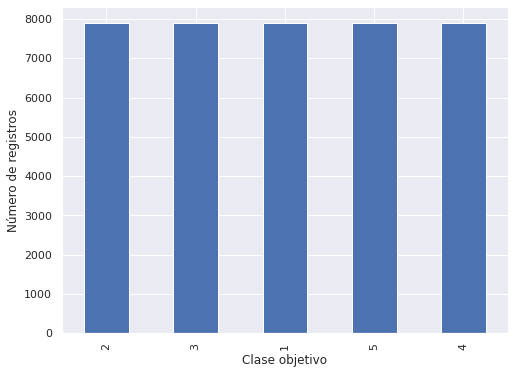

In [124]:
#Vemos el balanceo que produce el ROS
count = y_train.value_counts() 
count.plot.bar() 
plt.ylabel('Número de registros') 
plt.xlabel('Clase objetivo') 
plt.show()

In [125]:
from sklearn import svm

#Entrenamos el SVM en un Kernel Polinomial debido a sus multiples clases en el target
svm_Ros = svm.SVC(kernel='poly', degree=3, C=1, probability=True)
start= time.time()
svm_Ros.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [126]:
y_train_pred = svm_Ros.predict(X_train) #Prediccion en Train
y_test_pred = svm_Ros.predict(X_test) #Prediccion en Test

y_test_proba = svm_Ros.predict_proba(X_test) #Prediccion en Test probability

In [127]:
resultados = guardo_resultados('Support Vector Machine - Random-Over-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [128]:
#Creamos la matriz de confusión
matriz_svm_ros = confusion_matrix(y_test, y_test_pred)

# Segunda técnica de Balanceo: Synthetic Minority Oversampling Technique (SMOTE)

### Random Forest Smote

In [129]:
df = dataset.copy()

In [130]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [131]:
from sklearn.ensemble import RandomForestClassifier
#Creamos un random forest
Random_Forest_Smote = RandomForestClassifier(random_state=11, n_estimators=500,
                               class_weight="balanced_subsample")

In [132]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [133]:
#Separamos en train y test
(X_train, X_test,
y_train, y_test) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [134]:
#Importamos Smote y lo aplicamos sobre train
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_train, y_train= oversample.fit_resample(X_train, y_train)

In [135]:
#Entrenamos el modelo 
start= time.time()
Random_Forest_Smote.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


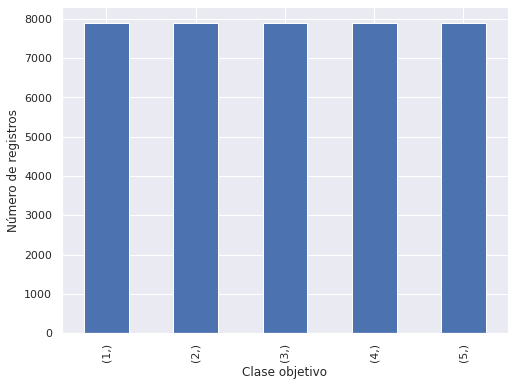

In [136]:
#Vemos el balanceo que produce el smote
count = y_train.value_counts() 
count.plot.bar() 
plt.ylabel('Número de registros') 
plt.xlabel('Clase objetivo') 
plt.show()

In [137]:
y_train_pred = Random_Forest_Smote.predict(X_train) #Prediccion en train
y_test_pred = Random_Forest_Smote.predict(X_test) #Prediccion en Test

y_test_proba = Random_Forest_Smote.predict_proba(X_test) #Prediccion en Test probability

In [138]:
resultados = guardo_resultados('Random Forest - SMOTE', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [139]:
#Creamos la matriz de confusión
matriz_randomForest_smote = confusion_matrix(y_test, y_test_pred)

### Catboost-Smote

In [140]:
from catboost import CatBoostClassifier


In [141]:
df = dataset.copy()

In [142]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [143]:
#Instanciamos el catboost para intentar balancear el dataset
cs_Smote = CatBoostClassifier(random_state=42, eval_metric='MultiClass', class_weights={1:5,2:1,3:5,4:5,5:5}, iterations=200)

In [144]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [145]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

In [146]:
#Importamos Smote y lo aplicamos sobre train
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_train, y_train= oversample.fit_resample(X_train, y_train)

In [147]:
#Entrenamos el modelo
start= time.time()
cs_Smote.fit(X_train,y_train, silent=True)
end= time.time()
tiempo_ejecucion = (end-start)

In [148]:
y_train_pred = cs_Smote.predict(X_train) #Prediccion en Train
y_test_pred = cs_Smote.predict(X_test) #Prediccion en Test

y_test_proba = cs_Smote.predict_proba(X_test) #Prediccion en Test probability

In [149]:
resultados = guardo_resultados('Catboost - SMOTE', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [150]:
#Creamos la matriz de confusión
matriz_catboost_smote = confusion_matrix(y_test, y_test_pred)

### Máquina de soporte vectorial-Smote

In [151]:
df = dataset.copy()

In [152]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [153]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [154]:
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (9083, 35), (9083,)
Test Data: (3893, 35), (3893,)


In [155]:
#Importamos Smote y lo aplicamos sobre train
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X_train, y_train= oversample.fit_resample(X_train, y_train)

In [156]:
from sklearn import svm

#Entrenamos el SVM en un Kernel Polinomial debido a sus multiples clases en el target
svm_Smote = svm.SVC(kernel='poly', degree=3, C=1, probability=True)
start= time.time()
svm_Smote.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [157]:
y_train_pred = svm_Smote.predict(X_train) #Prediccion en Train
y_test_pred = svm_Smote.predict(X_test) #Prediccion en Test

y_test_proba= svm_Smote.predict_proba(X_test) #Prediccion en Test probability

In [158]:
resultados = guardo_resultados('Support Vector Machine - SMOTE', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [159]:
#Creamos la matriz de confusión
matriz_svm_smote = confusion_matrix(y_test, y_test_pred)

# Tercera técnica: Under_Sampling (se dropeará cierta cantidad de datos de la clase mayoritaria para que nos quede un dataset mas balanceado)

In [160]:
dfcopia= dataset.copy()

In [161]:
#Submuestra (aleatoria y de n filas) de la clase mayoritaria 
subm_may= dfcopia[dfcopia['causa'] == 2].sample(n=2000,random_state=42)

In [162]:
#dataset sin la clase mayoritaria
df_sin_may = dfcopia.drop(dfcopia[dfcopia['causa']==2].index)

In [163]:
#Union de los dos dataframe creados
dfbal= df_sin_may.append(subm_may,ignore_index=True)

In [164]:
dfbal.groupby('causa').size()

causa
1     534
2    2000
3     830
4     104
5     215
dtype: int64

### KNN undersampling

In [165]:
df=dfbal.copy()

In [166]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [167]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

Fit y transformacion del X_train


In [168]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden (como si lo tiene por ejemplo, los meses del año)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(X_train[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
X_train.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
X_train= pd.concat([X_train, _ohe],axis=1)
X_train.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [169]:
from sklearn.preprocessing import StandardScaler
#Instanciamos standar scaler
se=StandardScaler()

# Escalamos los datos
X_train=pd.DataFrame(se.fit_transform(X_train),columns=X_train.columns)

In [170]:
#Instanciar PCA 
from sklearn.decomposition import PCA
pca=PCA(random_state=42,n_components=0.90)

#Transformamos el data frame
X_train_decomp=pca.fit_transform(X_train)

In [171]:
#Mostramos cantidad de columnas (19, que son las componentes que explican el 90% de variabilidad)
X_train_decomp.shape

(2578, 18)

Transformacion de los datos del X_test

In [172]:
#Se realiza One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(X_test[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
X_test.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
X_test= pd.concat([X_test, _ohe],axis=1)
X_test.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [173]:
from sklearn.preprocessing import StandardScaler

# Escalamos los datos
X_test=pd.DataFrame(se.transform(X_test),columns=X_test.columns)

#Transformamos el data frame
X_test_decomp=pca.transform(X_test)

#Mostramos cantidad de columnas (19, que son las componentes que explican el 90% de variabilidad)
X_test_decomp.shape

(1105, 18)

In [174]:
#Importamos el modelo
from sklearn.neighbors import KNeighborsClassifier

In [175]:
#Entrenamos el modelo
knn_undersampling = KNeighborsClassifier()
start= time.time()
knn_undersampling.fit(X_train_decomp,y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [176]:
y_train_pred = knn_undersampling.predict(X_train_decomp) #Prediccion en Train
y_test_pred = knn_undersampling.predict(X_test_decomp) #Prediccion en Test

y_test_proba = knn_undersampling.predict_proba(X_test_decomp) #Prediccion en Test probability

In [177]:
resultados = guardo_resultados('k-Nearest-Neighbor - Random-Under-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [178]:
#Creamos la matriz de confusión
matriz_knn_rus = confusion_matrix(y_test, y_test_pred)

### RANDOM FOREST Undersampling

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [180]:
df=dfbal.copy()

In [181]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [182]:
#Separamos en X e y
X = df.drop(["causa"], axis=1)
y = df["causa"]
#Separamos en train y test!
(X_train, X_test,
y_train, y_test) = train_test_split(X,
                                    y,
                                    stratify=y,
                                    test_size=0.30,
                                    random_state=11)

In [183]:
#Creamos un arbol de decisión sencillo y lo fiteamos
tree_undersampling = DecisionTreeClassifier(random_state=42)
start= time.time()
tree_undersampling.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [184]:
y_train_pred = tree_undersampling.predict(X_train) #Prediccion en train
y_test_pred = tree_undersampling.predict(X_test) #Prediccion en Test

y_test_proba = tree_undersampling.predict_proba(X_test) #Prediccion en Test probability

In [185]:
resultados = guardo_resultados('Arbol de decision - Random-Under-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [186]:
#Creamos la matriz de confusión
matriz_decisionTree_rus = confusion_matrix(y_test, y_test_pred)

In [187]:
#Creamos un random forest
Random_Forest_rus = RandomForestClassifier(random_state=11, n_estimators=200,
                               class_weight="balanced", max_features="log2")
#Entrenamos el modelo
start= time.time()
Random_Forest_rus.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [188]:
y_train_pred = Random_Forest_rus.predict(X_train) #Prediccion en train
y_test_pred = Random_Forest_rus.predict(X_test) #Prediccion en Test

y_test_proba = Random_Forest_rus.predict_proba(X_test) #Prediccion en Test probability

In [189]:
resultados = guardo_resultados('Random Forest - Random-Under-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [190]:
#Creamos la matriz de confusión
matriz_randomForest_rus = confusion_matrix(y_test, y_test_pred)

### CATBOOST Undersampling

In [191]:
df=dfbal.copy()

In [192]:
from catboost import CatBoostClassifier    

In [193]:
#Variables categóricas para catboost
cat_features = ['idprovincia', 'DIR_VIENTO']

In [194]:
#Instanciamos el catboost para intentar balancear el dataset
cs_undersampling = CatBoostClassifier(random_state=42, eval_metric='MultiClass', class_weights={1:5,2:1,3:5,4:5,5:5}, iterations=200)

In [195]:
#Dividimos en X e y 
X = df.drop(('causa'), axis=1)
y = df[['causa']]

In [196]:
#Me quedo con 30% para test y 70% para train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y) 

In [197]:
#Entrenamos el modelo
start= time.time()
cs_undersampling.fit(X_train,y_train, cat_features = ['idprovincia', 'DIR_VIENTO'], silent=True)
end= time.time()
tiempo_ejecucion = (end-start)

In [198]:
y_train_pred = cs_undersampling.predict(X_train) #Prediccion en Train
y_test_pred = cs_undersampling.predict(X_test) #Prediccion en Test

y_test_proba = cs_undersampling.predict_proba(X_test) #Prediccion en Test probability

In [199]:
resultados = guardo_resultados('Catboost - Random-Under-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [200]:
#Creamos la matriz de confusión
matriz_catboost_rus = confusion_matrix(y_test, y_test_pred)

### Support Vector Machine (Polinomial) Undersampling

In [201]:
df=dfbal.copy()

In [202]:
#Comenzamos a realizar One hot encoding con las variables que no tienen un orden 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore') #Si se agregaría otra variable seguiría funcionando
temporal = ohe.fit_transform(df[['idprovincia','DIR_VIENTO']]).toarray()

columns = []
for x in ohe.categories_:
    for y in x:
        columns.append(y)
_ohe = pd.DataFrame(temporal, columns=columns)
df.reset_index(drop=True, inplace=True)
_ohe.reset_index(drop=True, inplace=True)
df= pd.concat([df, _ohe],axis=1)
df.drop(['idprovincia','DIR_VIENTO'], axis=1, inplace=True)

In [203]:
#Dividimos en X e y 
X = df.drop('causa', axis=1)
y = df['causa']

In [204]:
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (2578, 35), (2578,)
Test Data: (1105, 35), (1105,)


In [205]:
from sklearn import svm

#Entrenamos el SVM en un Kernel Polinomial debido a sus multiples clases en el target
svm_undersampling = svm.SVC(kernel='poly', degree=3, C=1, probability=True)
start= time.time()
svm_undersampling.fit(X_train, y_train)
end= time.time()
tiempo_ejecucion = (end-start)

In [206]:
y_train_pred = svm_undersampling.predict(X_train) #Prediccion en Train
y_test_pred = svm_undersampling.predict(X_test) #Prediccion en Test

y_test_proba = svm_undersampling.predict_proba(X_test) #Prediccion en Test probability

In [207]:
resultados = guardo_resultados('Support Vector Machine - Random-Under-Sampling', y_test, y_test_pred, y_test_proba, tiempo_ejecucion)
resultados_df = resultados_df.append(resultados, ignore_index=True)

In [208]:
#Creamos la matriz de confusión
matriz_svm_rus = confusion_matrix(y_test, y_test_pred)

## Resultado de las metricas de evaluacion sobre los modelos de Clasificacion

## Matriz de confusion

In [209]:
matrices_knn = {'K-Nearest-Neighbor': matriz_knn, 'K-Nearest-Neighbor\nRandom-Under-Sampling': matriz_knn_rus}
matrices_decisionTree = {'Decision Tree': matriz_decisionTree, 'Decision Tree\nRandom-Under-Sampling': matriz_decisionTree_rus}
matrices_randomForest = {'Random Forest': matriz_randomForest, 'Random Forest\nRandom-Over-Sampling': matriz_randomForest_ros, 'Random Forest\nSMOTE': matriz_randomForest_smote, 'Random Forest\nRandom-Under-Sampling': matriz_randomForest_rus}
matrices_catboost = {'Catboost': matriz_catboost, 'Catboost\nRandom-Over-Sampling': matriz_catboost_ros, 'Catboost\nSMOTE': matriz_catboost_smote, 'Catboost\nRandom-Under-Sampling': matriz_catboost_rus}
matrices_svm = {'Support Vector Machine': matriz_svm, 'Support Vector Machine\nRandom-Over-Sampling': matriz_svm_ros, 'Support Vector Machine\nSMOTE': matriz_svm_smote, 'Support Vector Machine\nRandom-Under-Sampling': matriz_svm_rus}


In [210]:
def mostrar_matriz(filas, columnas, modelo):
  import warnings
  warnings.filterwarnings("ignore",category=UserWarning)
  if filas < 2:
    x,y = 14,6
  else:
    x,y = 14,10
  fig, axn = plt.subplots(filas, columnas, sharex=True, sharey=True,figsize=(x,y))
  cbar_ax = fig.add_axes([.91, .3, .03, .4])

  for i, ax in enumerate(axn.flat):
      k = list(modelo)[i]
      ax1 = sns.heatmap(modelo[k],
                  ax=ax, 
                  cbar=i==0,
                  annot=True,
                  cmap='Blues',
                  fmt='g',
                  cbar_ax=None if i else cbar_ax)
      ax1.set_title(k,fontsize=20)
      ax1.set_xticklabels(range(1,6,1))
      ax1.set_yticklabels(range(1,6,1))  

    # Create a big subplot
      ax = fig.add_subplot(111, frame_on=False)

      ax.set_xticks([])
      ax.set_yticks([])

      ax.set_xlabel('Predicción', labelpad=30, fontsize=15) # Use argument `labelpad` to move label downwards.
      ax.set_ylabel('Clase Verdadera', labelpad=35, fontsize=15)

      fig.tight_layout(rect=[0, 0, .9, 1])

In [211]:
#RESULTADO DE LAS METRICAS DE CLASIFICACION
resultados_df

Método  Accuracy    Recall  \
0                               k-Nearest-Neighbor  0.862831  0.862831   
1                                Arbol de Decision  0.772669  0.772669   
2                                    Random Forest  0.871821  0.871821   
3                                         Catboost  0.826355  0.826355   
4                           Support Vector Machine  0.869766  0.869766   
5             Random Forest - Random-Over-Sampling  0.866684  0.866684   
6                  Catboost - Random-Over-Sampling  0.499101  0.499101   
7    Support Vector Machine - Random-Over-Sampling  0.665810  0.665810   
8                            Random Forest - SMOTE  0.855381  0.855381   
9                                 Catboost - SMOTE  0.703057  0.703057   
10                  Support Vector Machine - SMOTE  0.666838  0.666838   
11      k-Nearest-Neighbor - Random-Under-Sampling  0.507692  0.507692   
12       Arbol de decision - Random-Under-Sampling  0.441629  0.441629   
13           Random Forest - Random-Under-Sampling  0.556561  0.556561   
14                Catboost - Random-Under-Sampling  0.489593  0.489593   
15  Support Vector Machine - Random-Under-Sampling  0.524887  0.524887   

    Precision    ROCAUC  F1-Score      Tiempo  
0    0.789151  0.595602  0.810536    0.002217  
1    0.791550  0.570500  0.781815    0.168328  
2    0.886013  0.741989  0.813550    3.527363  
3    0.790591  0.517953  0.806863   13.016062  
4    0.886727  0.420585  0.809185    5.807515  
5    0.791670  0.748906  0.814361   52.028114  
6    0.829066  0.744157  0.597705    8.197873  
7    0.834127  0.500000  0.708251  727.717592  
8    0.787795  0.753814  0.813520   64.490147  
9    0.798973  0.724738  0.744262   12.953046  
10   0.833735  0.500000  0.708688  740.991519  
11   0.457997  0.632401  0.460659    0.001257  
12   0.454825  0.574690  0.447603    0.046729  
13   0.497379  0.732526  0.463363    1.364995  
14   0.552612  0.751714  0.504501    6.222415  
15   0.750619  0.469886  0.361346    1.178111

Tomamos la métrica F1-Score como la más apta para definir nuestros modelos

In [212]:
resultados_df.sort_values(['F1-Score'], ascending=[False])

Método  Accuracy    Recall  \
5             Random Forest - Random-Over-Sampling  0.866684  0.866684   
2                                    Random Forest  0.871821  0.871821   
8                            Random Forest - SMOTE  0.855381  0.855381   
0                               k-Nearest-Neighbor  0.862831  0.862831   
4                           Support Vector Machine  0.869766  0.869766   
3                                         Catboost  0.826355  0.826355   
1                                Arbol de Decision  0.772669  0.772669   
9                                 Catboost - SMOTE  0.703057  0.703057   
10                  Support Vector Machine - SMOTE  0.666838  0.666838   
7    Support Vector Machine - Random-Over-Sampling  0.665810  0.665810   
6                  Catboost - Random-Over-Sampling  0.499101  0.499101   
14                Catboost - Random-Under-Sampling  0.489593  0.489593   
13           Random Forest - Random-Under-Sampling  0.556561  0.556561   
11      k-Nearest-Neighbor - Random-Under-Sampling  0.507692  0.507692   
12       Arbol de decision - Random-Under-Sampling  0.441629  0.441629   
15  Support Vector Machine - Random-Under-Sampling  0.524887  0.524887   

    Precision    ROCAUC  F1-Score      Tiempo  
5    0.791670  0.748906  0.814361   52.028114  
2    0.886013  0.741989  0.813550    3.527363  
8    0.787795  0.753814  0.813520   64.490147  
0    0.789151  0.595602  0.810536    0.002217  
4    0.886727  0.420585  0.809185    5.807515  
3    0.790591  0.517953  0.806863   13.016062  
1    0.791550  0.570500  0.781815    0.168328  
9    0.798973  0.724738  0.744262   12.953046  
10   0.833735  0.500000  0.708688  740.991519  
7    0.834127  0.500000  0.708251  727.717592  
6    0.829066  0.744157  0.597705    8.197873  
14   0.552612  0.751714  0.504501    6.222415  
13   0.497379  0.732526  0.463363    1.364995  
11   0.457997  0.632401  0.460659    0.001257  
12   0.454825  0.574690  0.447603    0.046729  
15   0.750619  0.469886  0.361346    1.178111

Además de la métrica F1-Score tomamos en cuenta el tiempo empleado en el entrenamiento del modelo

In [213]:
resultados_df_pct = resultados_df.copy()
resultados_df_pct[['Accuracy','Recall','Precision','ROCAUC','F1-Score']]= resultados_df_pct[['Accuracy','Recall','Precision','ROCAUC','F1-Score']].applymap("{:.0%}".format)
resultados_df_pct.sort_values(['F1-Score','Tiempo'], ascending=[False, True])

Método Accuracy Recall Precision  \
0                               k-Nearest-Neighbor      86%    86%       79%   
2                                    Random Forest      87%    87%       89%   
4                           Support Vector Machine      87%    87%       89%   
3                                         Catboost      83%    83%       79%   
5             Random Forest - Random-Over-Sampling      87%    87%       79%   
8                            Random Forest - SMOTE      86%    86%       79%   
1                                Arbol de Decision      77%    77%       79%   
9                                 Catboost - SMOTE      70%    70%       80%   
7    Support Vector Machine - Random-Over-Sampling      67%    67%       83%   
10                  Support Vector Machine - SMOTE      67%    67%       83%   
6                  Catboost - Random-Over-Sampling      50%    50%       83%   
14                Catboost - Random-Under-Sampling      49%    49%       55%   
11      k-Nearest-Neighbor - Random-Under-Sampling      51%    51%       46%   
13           Random Forest - Random-Under-Sampling      56%    56%       50%   
12       Arbol de decision - Random-Under-Sampling      44%    44%       45%   
15  Support Vector Machine - Random-Under-Sampling      52%    52%       75%   

   ROCAUC F1-Score      Tiempo  
0     60%      81%    0.002217  
2     74%      81%    3.527363  
4     42%      81%    5.807515  
3     52%      81%   13.016062  
5     75%      81%   52.028114  
8     75%      81%   64.490147  
1     57%      78%    0.168328  
9     72%      74%   12.953046  
7     50%      71%  727.717592  
10    50%      71%  740.991519  
6     74%      60%    8.197873  
14    75%      50%    6.222415  
11    63%      46%    0.001257  
13    73%      46%    1.364995  
12    57%      45%    0.046729  
15    47%      36%    1.178111

### Matrices de confusión K-Nearest-Neighbor

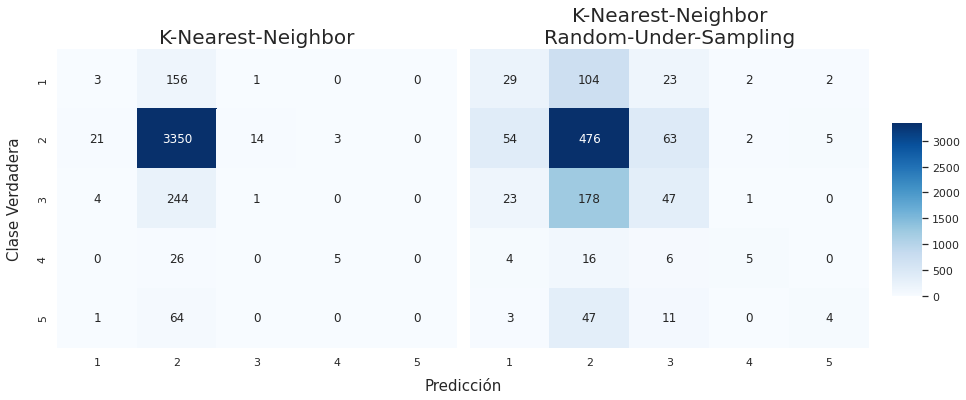

In [214]:
mostrar_matriz(1,2,matrices_knn)

### Matrices de confusión Decision Tree

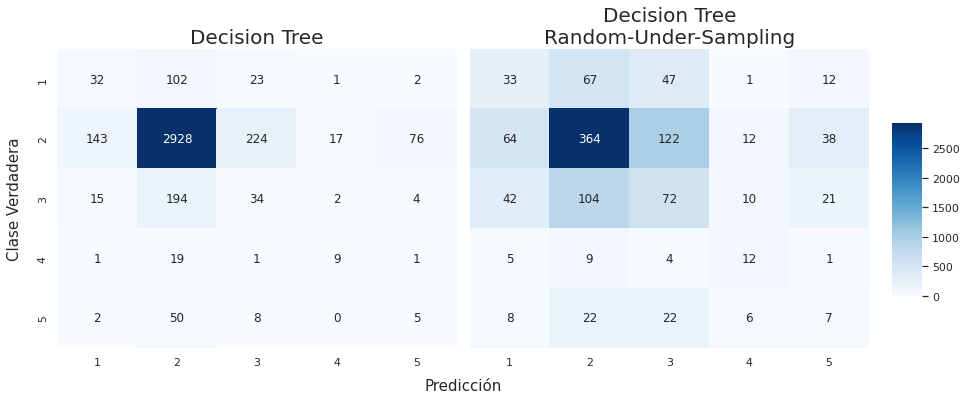

In [215]:
mostrar_matriz(1,2, matrices_decisionTree)

### Matrices de confusión Random Forest

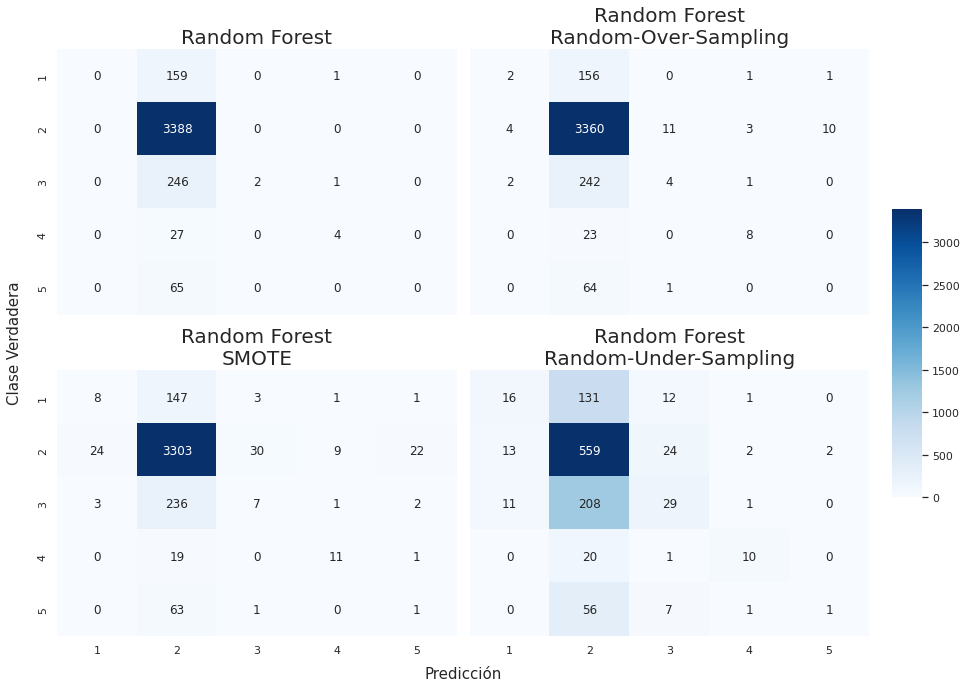

In [216]:
mostrar_matriz(2,2, matrices_randomForest)

### Matrices de confusión Catboost

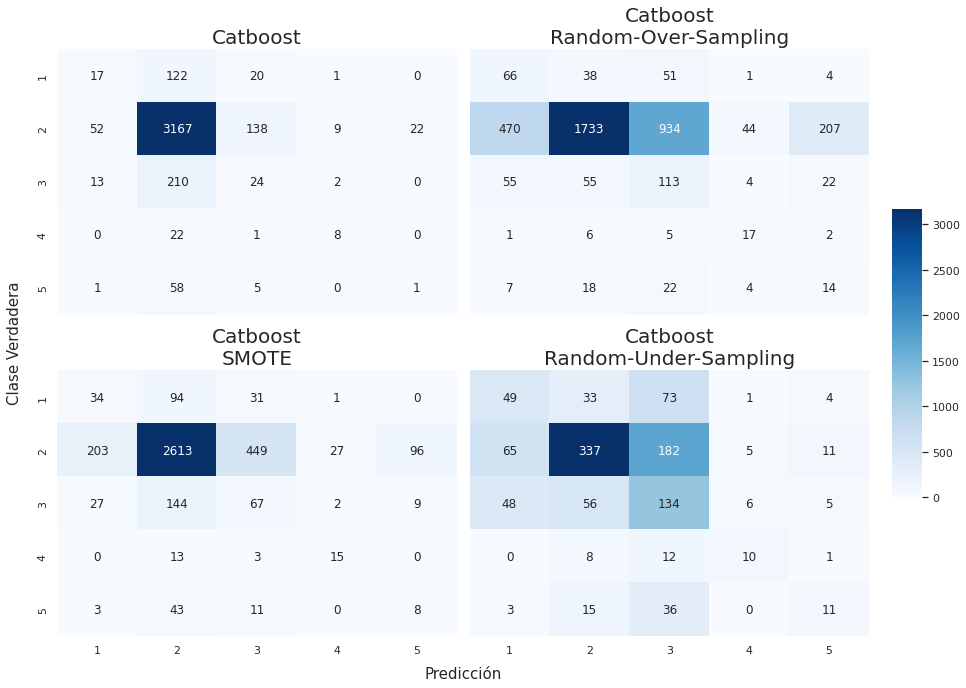

In [217]:
mostrar_matriz(2,2, matrices_catboost)

### Matrices de confusion Support Vector Machine

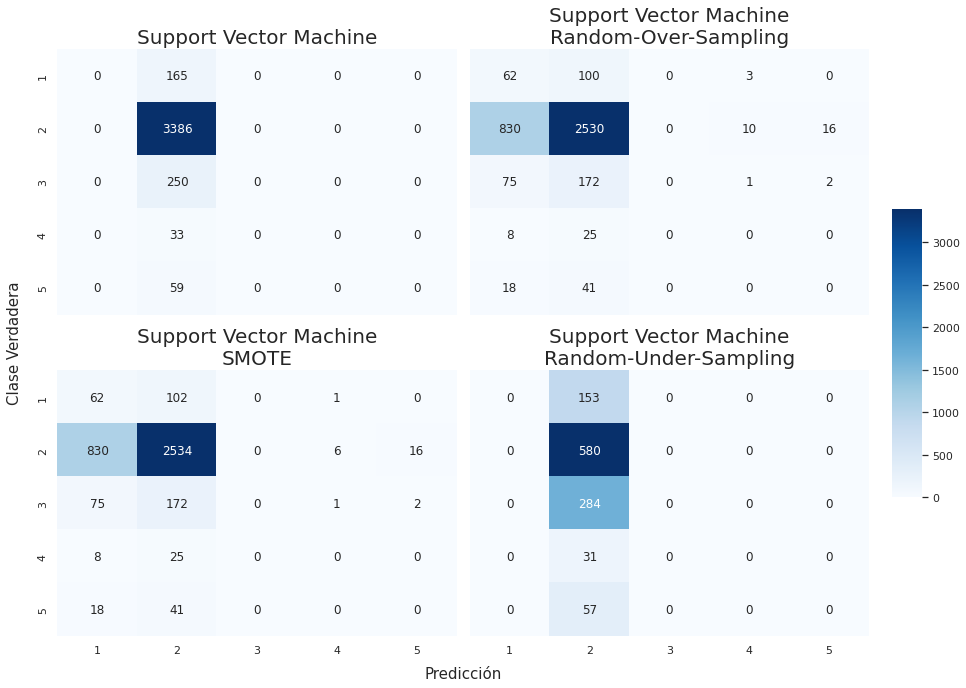

In [218]:
mostrar_matriz(2,2, matrices_svm)